# Tutorial for the Flatten Function
This tutorial will cover TOFFEE's flatten() function used to detrend time-series photometric light curve data from which TOFFEE can identify stellar flares. Let us first generate an example light curve, courtesy of AltaiPony made by Ekaterina Ilin (https://github.com/ekaterinailin/AltaiPony/tree/master):

In [21]:
import toffee
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def generate_lightcurve(errorval, a1, a2,period1, period2, quad, cube,
                        mean=3400., dur=10):
    
    time = np.arange(0, 10 + 10 * np.pi,.0008)

    # define the flux
    flux = (np.random.normal(0,errorval,time.shape[0]) +
            mean + 
            a1*mean*np.sin(period1*time +1.)  +
            a2*mean*np.sin(period2*time) +
            quad*(time-25)**2 -
            cube*(time-25)**3)

    # add a gap in the data
    # flux[5600:7720] = np.nan

    # add big and long flare
    l = 1000
    flux[5280:5280 + l] = flux[5280:5280 + l] + np.linspace(1000,250,l)

    # add tiny flare
    l = 20
    flux[15280:15280 + l] = flux[15280:15280 + l] + np.linspace(100,60,l)

    # add intermediate flare
    l, s = 200, 25280
    flux[s:s + l] = flux[s:s + l] + np.linspace(200,60,l)

    # typically Kepler and TESS underestimate the real noise
    err = np.full_like(time,errorval/3*2)

    return time, flux, err

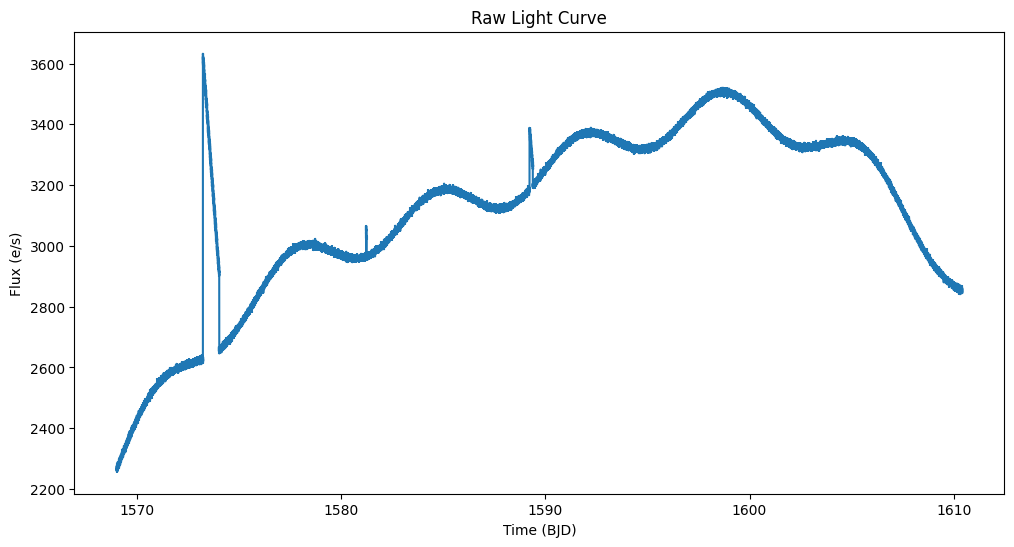

In [14]:
# Generate a light curve with specified errorbars, sinusoids, flares, and quadratic trend
t, flux, err = generate_lightcurve(5, 0.04, 0.02, 0.2, 0.9, -2, 0 ,dur=10) 

# Shift time to align with some actual TESS orbits
t = t + 1569
# t = t + 1469

# Plot 'raw' light curve
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(t, flux, err)
ax.set_title('Raw Light Curve')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (e/s)')
plt.show()

Above, we have simulated a star from which we observe 3,400 electrons per second on average. We've also included several "flares" and two sinusoids of constant amplitude and period to serve as spots and/or pulsations, as well as a large quadratic trend. We also shift the time to align at the boundary of two TESS orbits. 

We will now walk through how TOFFEE detrends each of the non-flare signatures in question. 

## Quadratic Flattening

A typical TESS light curve contains many variations both instrumental and physical that impede or obscure a flare. For instance, TESS often conducts momentum dumps or other movements throughout each sector that affect its observations, creating a roughly quadratic trend over the course of the sector. 

TOFFEE accounts for this by separating the light curve by TESS sector and fitting a quadratic to each segment with scipy, which is done by default, and automatically normalizes the data around 1. (Note: As this is a consistent behavior across all TESS light curves, this step cannot be turned off)


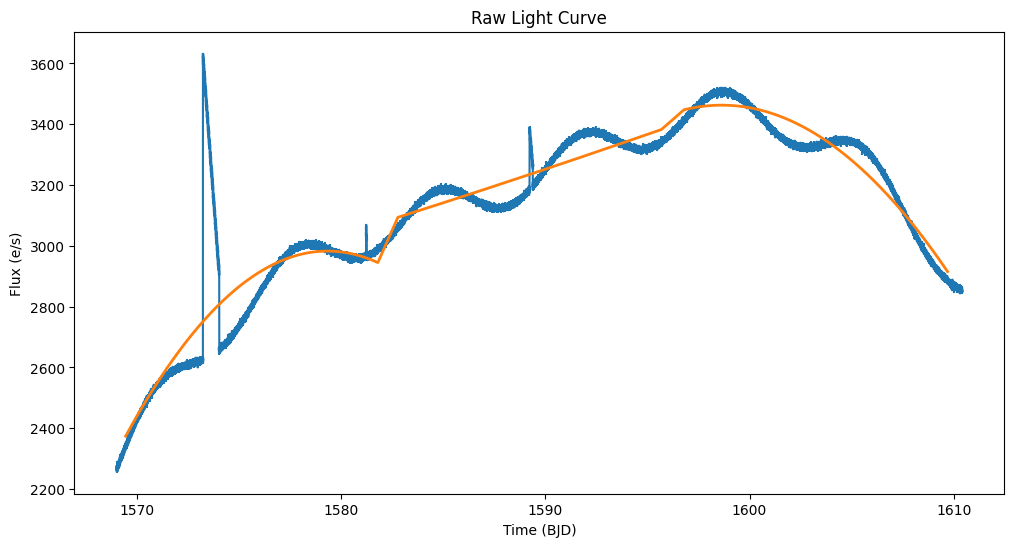

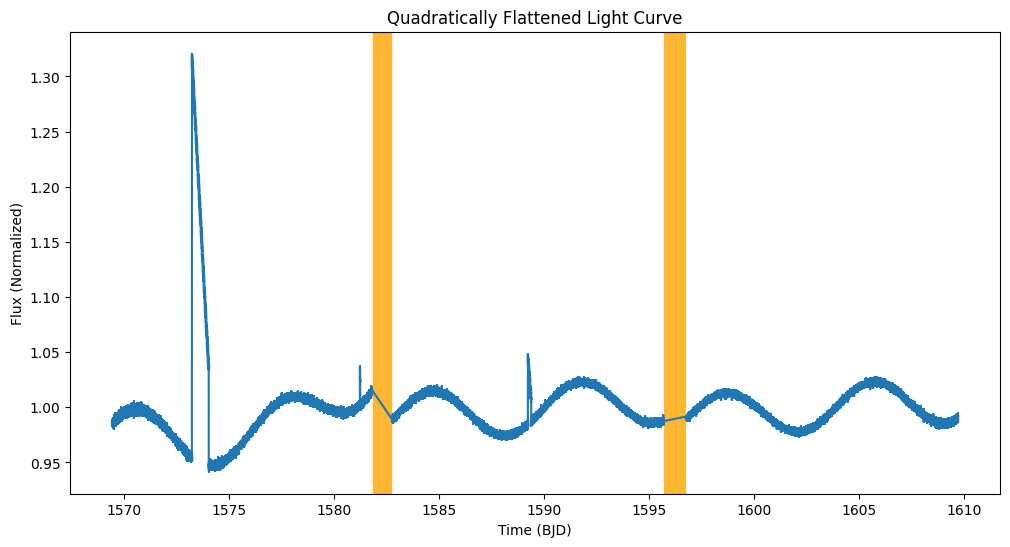

In [4]:
# Execute TOFFEE flattening for only sector-long quadratic trends
orbit_t, lc_quad, periodic = toffee.flatten(t, flux, err)

# Plot raw light curve with extracted trend
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(t, flux, err)
ax.plot(orbit_t, lc_quad[2], zorder=3, lw=2)
# ax.scatter(orbit_t, lc_quad[2], zorder=3, c='orange')
ax.set_title('Raw Light Curve')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (e/s)')
plt.show()

# Plot quadratic flattened light curve
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(orbit_t, lc_quad[0], lc_quad[1])
ax.axvline(1596.22, lw=16, alpha=0.8, c='orange')
ax.axvline(1582.3, lw=14, alpha=0.8, c='orange')

ax.set_title('Quadratically Flattened Light Curve')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (Normalized)')
plt.show()

From our example above, TOFFEE has removed the long term quadratic trend while preserving the double sinusoid and flares!

Important to note that if you only call flatten() for the quadratic flattening, TOFFEE returns to you three values:
- orbit_t: 1D array of observation times
- lc_quad: 3-element long list containing the quadratic flattened flux, errors, and extracted trend
- periodic: boolean indicating whether the remaining light curve contains a significant periodic signal. Is always false if 'periodogram' argument is not provided.

TOFFEE returns a time array back to you because there could be points in the light curve that erroneously do not fall under any of the TESS sector times, causing them to be excluded and inducing an array mismatch. Use the TOFFEE returned time array rather than any raw file array from your light curve when using TOFFEE. In our example, sections of the generated light curve occurred during a TESS data download, marked in orange.

## Constant Window Flattening

If desired, TOFFEE can then flatten the light curve further with a constant window using the wotan package with Tukey's biweight method by providing a window length in days to short_window.  If you are unfamiliar with this package/method, you may learn more at https://wotan.readthedocs.io/en/latest/Interface.html.

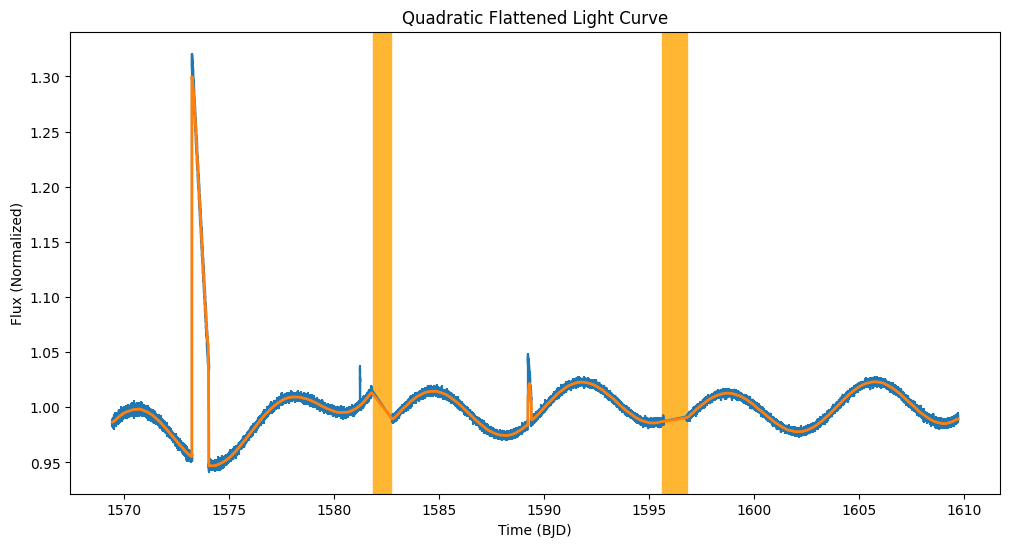

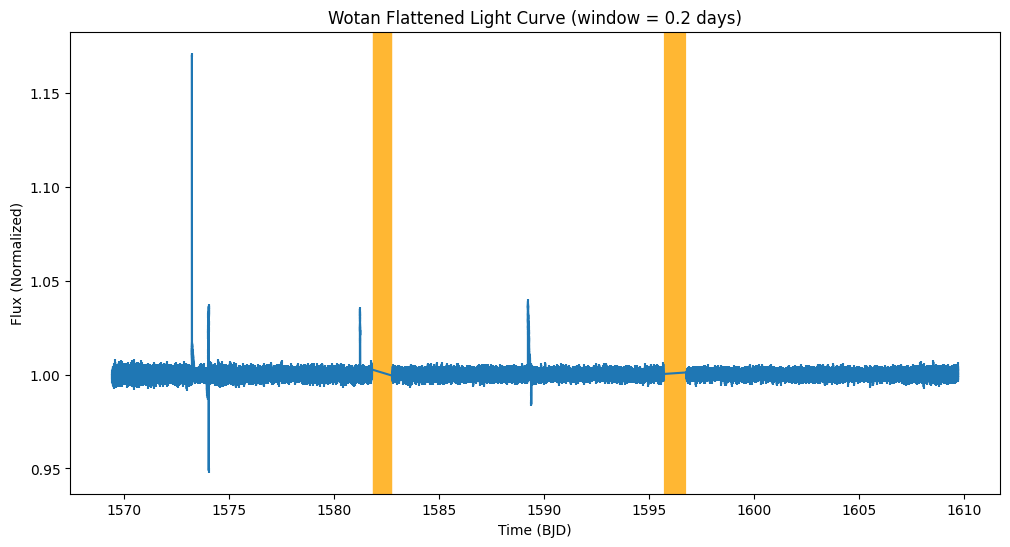

In [5]:
# Execute TOFFEE flattening for only sector-long quadratic trends
orbit_t, lc_quad, lc_wotan, periodic = toffee.flatten(t, flux, err, short_window=0.2)

# Plot quadratic flattened light curve with extracted trend
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(orbit_t, lc_quad[0], lc_quad[1])
ax.plot(orbit_t, lc_wotan[2], zorder=3, lw=2)
ax.axvline(1596.22, lw=19, alpha=0.8, c='orange')
ax.axvline(1582.3, lw=14, alpha=0.8, c='orange')
ax.set_title('Quadratic Flattened Light Curve')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (Normalized)')
plt.show()

# Plot wotan flattened light curve
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(orbit_t, lc_wotan[0], lc_wotan[1])
ax.axvline(1596.22, lw=16, alpha=0.8, c='orange')
ax.axvline(1582.3, lw=14, alpha=0.8, c='orange')

ax.set_title('Wotan Flattened Light Curve (window = 0.2 days)')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (Normalized)')
plt.show()

This time, TOFFEE returns to you four values:
- orbit_t: 1D array of observation times
- lc_quad: 3-element long list containing the quadratic flattened flux, errors, and extracted trend
- lc_wotan: 3-element long list containing the wotan flattened flux, errors, and extracted trend
- periodic: boolean indicating whether the remaining light curve contains a significant periodic signal. Is always false if 'periodogram' argument is not provided.

For most uses, this step is sufficient in removing long time scale events such as star spots while preserving shorter time scale ones, namely flares. Our example light curve has been removed of all sinusoidal signals, while the flares are preserved!

However, for certain light curves, stellar activity like spots may occur on similar timescale as flares. Attempting to flatten with shorter constant windows will "eat into" our flares. As such, if you desire near complete preservation of flares, we recommend a window no shorter than 0.2 days. Let us demonstrate this with a different generated light curve:

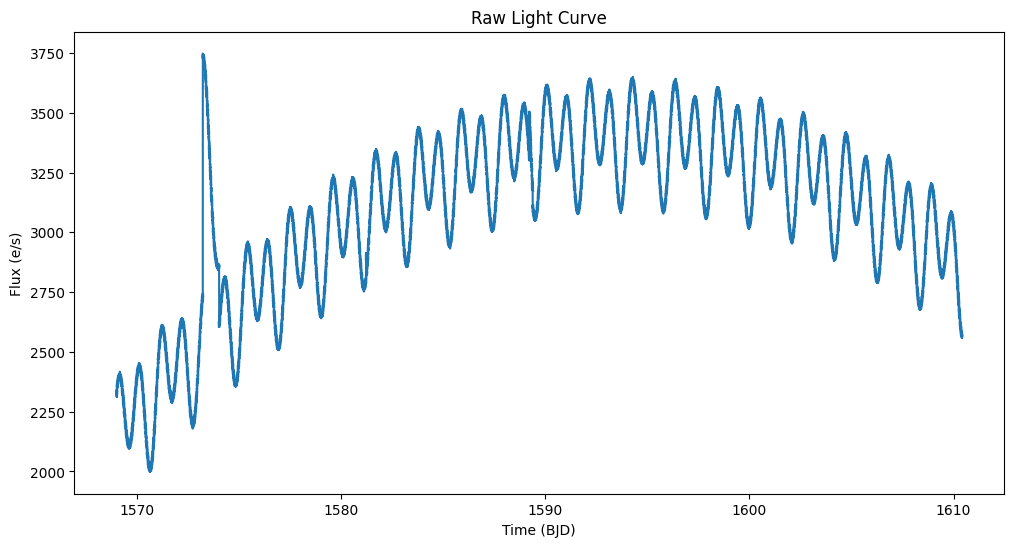

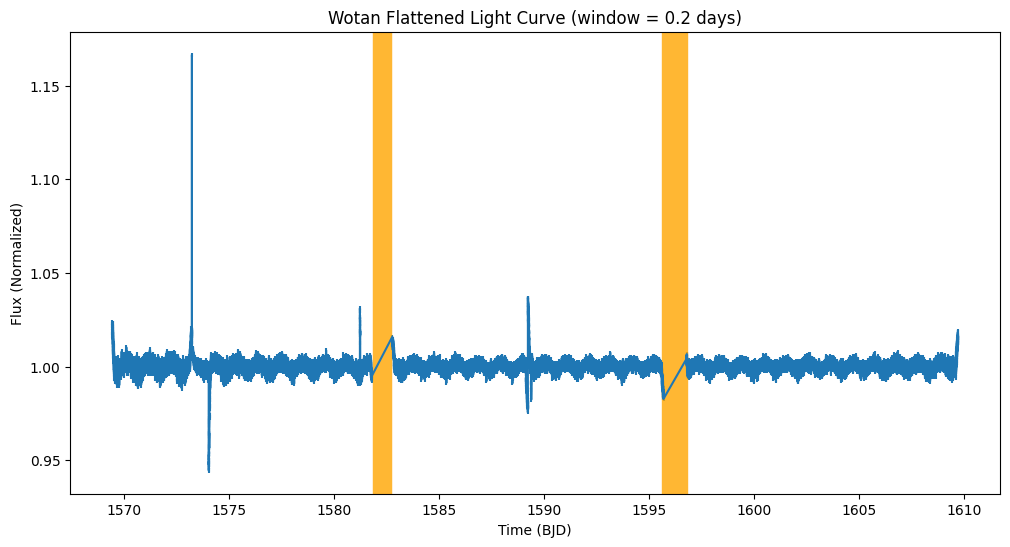

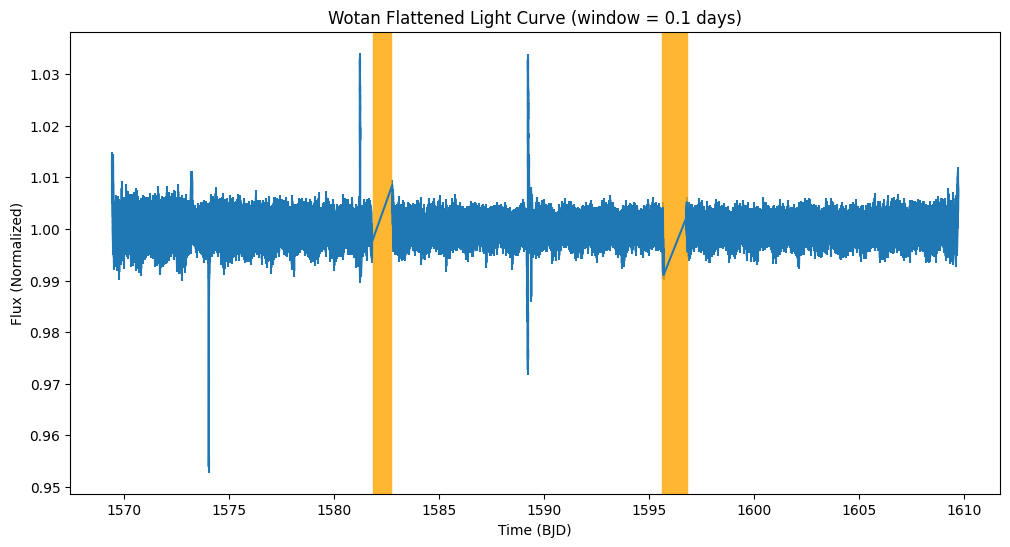

In [6]:
# Generate a new light curve with higher frequency sinusoids
t, flux, err = generate_lightcurve(5, 0.06, 0.03, 6, 3, -2, 0) 

# Shift time to align with some actual TESS orbits
t = t + 1569

# Plot 'raw' light curve
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(t, flux, err)
ax.set_title('Raw Light Curve')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (e/s)')
plt.show()

# Execute TOFFEE flattening for only sector-long quadratic trends
orbit_t, lc_quad, lc_wotan, periodic = toffee.flatten(t, flux, err, short_window=0.2)


# Plot quadratic flattened light curve
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(orbit_t, lc_wotan[0], lc_wotan[1])
ax.axvline(1596.22, lw=19, alpha=0.8, c='orange')
ax.axvline(1582.3, lw=14, alpha=0.8, c='orange')
ax.set_title('Wotan Flattened Light Curve (window = 0.2 days)')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (Normalized)')
plt.show()

# Execute TOFFEE flattening for only sector-long quadratic trends
orbit_t, lc_quad, lc_wotan, periodic = toffee.flatten(t, flux, err, short_window=0.1)

# Plot quadratic flattened light curve
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(orbit_t, lc_wotan[0], lc_wotan[1])
ax.axvline(1596.22, lw=19, alpha=0.8, c='orange')
ax.axvline(1582.3, lw=14, alpha=0.8, c='orange')
ax.set_title('Wotan Flattened Light Curve (window = 0.1 days)')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (Normalized)')
plt.show()

With a light curve with high frequency periodicity, the 0.2 day window is not enough to fully flatten the sinusoidal signal. Indeed, going to 0.1 days doesn't fully solve the problem either, and has also reduced the normalized flux amplitude of the flares. For the purposes of flare detection, this is not ideal. 

## Progressive Window Flattening
If further flattening is still needed after the ≥ 0.2 day constant window from above, TOFFEE also provides progressive flattening. 

The light curve is separated by TESS sector once again, and a lomb-scargle periodogram is conducted upon each segment; if the False Alarm Probability is below 20%, the most probable signal period is saved, and TOFFEE flattens that segment via wotan at a window length equal to half of this peak period using the 'median' method. The periodogram and flattening are reattemped until the periodogram FAP reaches above 20%, or if it reaches 8 cycles. 

This process is engaged when the 'periodogram' argument is provided. It should be a list of two elements containing the lower and upper frequency limits you wish TOFFEE to search for a periodic signal over.

As the progressive flattening adjusts to the light curve periodicity, it will often reach below 0.2 days and "eat into" the amplitude of longer flares. Similarly, any signs of transits will be warped but still present. Using the high frequency example above, let's see this in action:

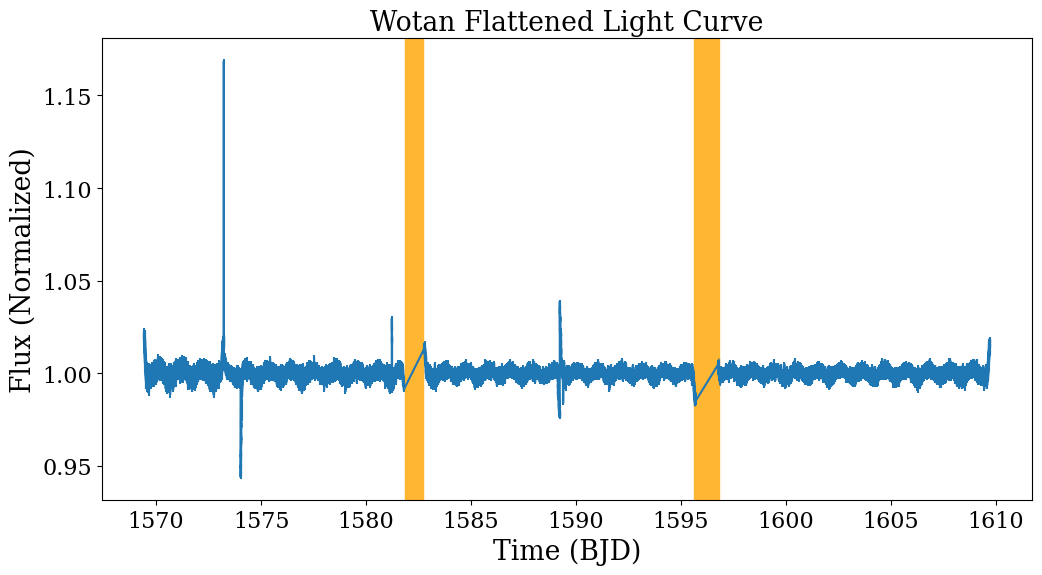

In [35]:
# Generate a new light curve with higher frequency sinusoids
t, flux, err = generate_lightcurve(5, 0.06, 0.03, 6, 3, -2, 0) 

# Shift time to align with some actual TESS orbits
t = t + 1569

orbit_t, lc_quad, lc_wotan, lc_flat, periodic = toffee.flatten(t, flux, err, short_window=0.2, periodogram=[1/1000, 1/7])

# Plot quadratic flattened light curve
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(orbit_t, lc_flat[0], lc_flat[1])
ax.axvline(1596.22, lw=19, alpha=0.8, c='orange')
ax.axvline(1582.3, lw=14, alpha=0.8, c='orange')
ax.set_title('Wotan Flattened Light Curve')
ax.set_xlabel('Time (BJD)')
ax.set_ylabel('Flux (Normalized)')

plt.show()


This time, TOFFEE returns to you five values:
- orbit_t: 1D array of observation times
- lc_quad: 3-element long list containing the quadratic flattened flux, errors, and extracted trend
- lc_wotan: 3-element long list containing the wotan flattened flux, errors, and extracted trend
- lc_flat: 3-element long list containing the progressive flattened flux, errors, and extracted trend
- periodic: boolean indicating whether the remaining light curve contains a significant periodic signal. Is always false if 'periodogram' argument is not provided.

Note: progressive flattening cannot be engaged without the constant window flattening. Always provide a value for 'short_window' and 'periodogram'. 